In [1]:
from threading import Thread
from agents.bfilter import BayesFilter
from agents.utils import hierarchical_sort, str2arr

import json
import numpy as np
import pickle as pkl
from sklearn.neighbors import KernelDensity
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
from multiprocessing import Pool, Queue
from tqdm import tqdm, tqdm_notebook, tnrange

In [2]:
# set filenames
# data we're standardizing on (from the one-hots)
standardization_f = 'resources/stripped_normalization.pkl'

# training data for kdes, this should be a dict of metrics keyed on task
training_f = 'resources/243_raw_data.pkl' 

# test data for kdes. this includes the task, metrics, and beliefs
test_f ='results/results_file_full_243_run0_90_each'



In [3]:
# load the standardization params
with open(standardization_f,'rb') as sfile:
    standard_m, standard_std = pkl.load(sfile)
print(standard_m.shape,standard_std.shape)
print(standard_m,standard_std)

(5,) (5,)
[7.02134345e+05 1.32097649e+05 2.18597774e-01 4.19621716e-01
 7.15822936e-02] [2.07865180e+05 5.35621885e+04 5.92860480e-02 2.26446118e-02
 3.14796257e-02]


In [98]:
# load the training data and parse out the overall means and stds
train_trajectories = []
train_labels = []
with open(training_f, 'rb') as trainfile:
    training_dict = pkl.load(trainfile)

train_test_set = []
for label, flattened_trajectories in training_dict.items():
    original_length = len(flattened_trajectories)
    leave_out_i = np.random.randint((len(flattened_trajectories)-1)/100) # skip the last one, which could be < 100
    left_out = flattened_trajectories[leave_out_i:leave_out_i+100]
    training_dict[label] = np.delete(flattened_trajectories,list(range(leave_out_i,leave_out_i+100)),0)
    train_test_set.append((left_out,label))
    assert len(training_dict[label]) + 100 == original_length

for label,steps in training_dict.items():
    print(label, steps.shape)
    extra = len(steps) % 100 # since we only use this to test with, lop off the extra
    if extra > 0:
        chunks = steps[:-extra,:].reshape(len(steps)//100,100,5)
    else:
        chunks = steps.reshape(len(steps)//100,100,5)
    for i in range(chunks.shape[0]):
        train_trajectories.append(chunks[i,:])
        train_labels.append(label)
        

all_training_data = np.concatenate([v for v in training_dict.values()])
    
train_m = np.mean(all_training_data,0)
train_std = np.std(all_training_data,0)
print(train_m.shape,train_std.shape)
print(train_m,train_std)

8358 8458
8550 8650
7646 7746
8069 8169
7337 7437
8522 8622
8276 8376
8879 8979
7567 7667
7554 7654
7860 7960
8228 8328
6465 6565
8338 8438
7748 7848
8372 8472
7195 7295
8410 8510
8224 8324
8104 8204
8453 8553
8178 8278
7680 7780
7365 7465
8300 8400
7575 7675
7627 7727
7317 7417
7500 7600
8261 8361
8122 8222
8969 9069
8277 8377
7534 7634
8415 8515
8752 8852
8262 8362
8827 8927
8462 8562
8333 8433
8055 8155
8475 8575
7505 7605
7518 7618
6957 7057
8591 8691
7504 7604
8323 8423
7978 8078
8524 8624
8234 8334
9080 9180
8551 8651
7854 7954
8446 8546
8500 8600
8482 8582
8327 8427
7686 7786
8237 8337
8538 8638
8375 8475
8126 8226
8359 8459
8301 8401
8729 8829
7621 7721
8354 8454
7567 7667
8246 8346
7884 7984
7832 7932
8186 8286
8016 8116
8304 8404
8030 8130
8228 8328
8867 8967
8102 8202
8258 8358
8481 8581
8201 8301
8695 8795
6816 6916
8423 8523
8868 8968
7486 7586
7491 7591
8114 8214
8424 8524
7596 7696
6558 6658
7677 7777
7469 7569
8175 8275
8283 8383
8172 8272
8322 8422
8225 8325
8401 8501


[-1.0, 0.0, 0.0, 1.0, 0.0] (8667, 5)
[1.0, 0.0, 1.0, -1.0, 1.0] (7573, 5)
[-1.0, 0.0, 0.0, -1.0, -1.0] (8384, 5)
[-1.0, -1.0, -1.0, -1.0, 0.0] (8263, 5)
[1.0, -1.0, -1.0, -1.0, 0.0] (8275, 5)
[-1.0, 1.0, 1.0, 0.0, 1.0] (8122, 5)
[1.0, 1.0, -1.0, 0.0, 0.0] (8463, 5)
[0.0, -1.0, -1.0, 1.0, 0.0] (8166, 5)
[1.0, 0.0, 1.0, 0.0, 0.0] (7795, 5)
[0.0, 1.0, 1.0, -1.0, 0.0] (7466, 5)
[1.0, 0.0, -1.0, -1.0, 1.0] (8396, 5)
[0.0, -1.0, -1.0, -1.0, -1.0] (8023, 5)
[1.0, 0.0, 1.0, 0.0, 1.0] (7555, 5)
[1.0, -1.0, 0.0, -1.0, 1.0] (8289, 5)
[0.0, -1.0, -1.0, 0.0, 1.0] (8416, 5)
[-1.0, 1.0, 1.0, 0.0, 0.0] (8115, 5)
[-1.0, -1.0, 0.0, -1.0, -1.0] (8163, 5)
[1.0, -1.0, 1.0, 1.0, 0.0] (7557, 5)
[1.0, -1.0, 0.0, 0.0, 0.0] (8321, 5)
[1.0, -1.0, -1.0, 1.0, 0.0] (8357, 5)
[-1.0, 1.0, -1.0, 0.0, -1.0] (8800, 5)
[0.0, 0.0, 1.0, 1.0, 1.0] (7703, 5)
[1.0, 1.0, -1.0, 0.0, 1.0] (8558, 5)
[-1.0, 1.0, -1.0, 1.0, 0.0] (8531, 5)
[1.0, 0.0, 1.0, 1.0, 0.0] (7609, 5)
[-1.0, -1.0, 0.0, 1.0, 1.0] (8471, 5)
[-1.0, -1.0, 0.0, 0.

In [85]:
steps[:-0,:].shape

(0, 5)

In [5]:
all_test_data = []
all_test_data_append = all_test_data.append
with open(test_f, 'r') as testfile:
    for row in testfile:
        result = json.loads(row)
        metrics = result['metrics']
        # metrics is a list of observations over each 100 steps
        for m in metrics:
            all_test_data_append(m)
all_test_data = np.array(all_test_data)
test_m = np.mean(all_test_data,0)
test_std = np.std(all_test_data,0)
print(test_m.shape,test_std.shape)
print(test_m,test_std)

(5,) (5,)
[6.97818515e+05 1.26980738e+05 2.21070745e-01 4.19481711e-01
 7.16673419e-02] [2.45247594e+05 5.27317480e+04 5.44752682e-02 2.00649051e-02
 3.04172704e-02]


In [100]:
test_trajectories = []
test_labels = []
test_dict = {}
with open(test_f, 'r') as testfile:
    for row in testfile:
        result = json.loads(row)
        metrics = result['metrics']
        raw_label = str(list(map(float,result['task'])))
        label = str(np.array(result['task'], dtype=float))
        test_trajectories.append(metrics)
        test_labels.append(label)
        if raw_label in test_dict:
            test_dict[raw_label] += metrics
        else:
            test_dict[raw_label] = metrics
test_test_set = []
for label, flattened_trajectories in test_dict.items():
    original_length = len(flattened_trajectories)
    leave_out_i = np.random.randint((len(flattened_trajectories)-1)/100) # skip the last one, which could be < 100
    left_out = flattened_trajectories[leave_out_i:leave_out_i+100]
    test_dict[label] = np.delete(flattened_trajectories,list(range(leave_out_i,leave_out_i+100)),0)
    test_test_set.append((left_out,label))
    assert len(test_dict[label]) + 100 == original_length
#NOTE: the train trajectories take out the test sample before creating trajectories, this does not
test_trajectories = np.array(test_trajectories)
# for i in range(len(test_labels)):
#     test_labels[i] = str(np.array(test_labels[i], dtype=float))
print(test_trajectories.shape, len(test_labels))

(14643,) 14643


8358 8458
8550 8650
7646 7746
8069 8169
7337 7437
8522 8622
8276 8376
8879 8979
7567 7667
7554 7654
7860 7960
8228 8328
6465 6565
8338 8438
7748 7848
8372 8472
7195 7295
8410 8510
8224 8324
8104 8204
8453 8553
8178 8278
7680 7780
7365 7465
8300 8400
7575 7675
7627 7727
7317 7417
7500 7600
8261 8361
8122 8222
8969 9069
8277 8377
7534 7634
8415 8515
8752 8852
8262 8362
8827 8927
8462 8562
8333 8433
8055 8155
8475 8575
7505 7605
7518 7618
6957 7057
8591 8691
7504 7604
8323 8423
7978 8078
8524 8624
8234 8334
9080 9180
8551 8651
7854 7954
8446 8546
8500 8600
8482 8582
8327 8427
7686 7786
8237 8337
8538 8638
8375 8475
8126 8226
8359 8459
8301 8401
8729 8829
7621 7721
8354 8454
7567 7667
8246 8346
7884 7984
7832 7932
8186 8286
8016 8116
8304 8404
8030 8130
8228 8328
8867 8967
8102 8202
8258 8358
8481 8581
8201 8301
8695 8795
6816 6916
8423 8523
8868 8968
7486 7586
7491 7591
8114 8214
8424 8524
7596 7696
6558 6658
7677 7777
7469 7569
8175 8275
8283 8383
8172 8272
8322 8422
8225 8325
8401 8501


In [97]:
len(train_test_set)

243

In [105]:
combined_train_test_dict = {}
for key in training_dict.keys():
    combined_train_test_dict[key] = np.concatenate([training_dict[key],test_dict[key]])
    assert combined_train_test_dict[key].shape[-1] == 5
    print(combined_train_test_dict[key].shape)
    

(14258, 5)
(14750, 5)
(13146, 5)
(13469, 5)
(13537, 5)
(14022, 5)
(14376, 5)
(15279, 5)
(12967, 5)
(13554, 5)
(13160, 5)
(14128, 5)
(12565, 5)
(14338, 5)
(13148, 5)
(14272, 5)
(13195, 5)
(14510, 5)
(14224, 5)
(13504, 5)
(13753, 5)
(13978, 5)
(12880, 5)
(12765, 5)
(13800, 5)
(12875, 5)
(13227, 5)
(13417, 5)
(12800, 5)
(14361, 5)
(14522, 5)
(15369, 5)
(13477, 5)
(13234, 5)
(13415, 5)
(15152, 5)
(14162, 5)
(15027, 5)
(14362, 5)
(13733, 5)
(13555, 5)
(15075, 5)
(12705, 5)
(13818, 5)
(12957, 5)
(14691, 5)
(13504, 5)
(13823, 5)
(14078, 5)
(15024, 5)
(14334, 5)
(15280, 5)
(14351, 5)
(14054, 5)
(13746, 5)
(14700, 5)
(14782, 5)
(14327, 5)
(13686, 5)
(14037, 5)
(15038, 5)
(14475, 5)
(14526, 5)
(14659, 5)
(14301, 5)
(15029, 5)
(13721, 5)
(13454, 5)
(13267, 5)
(13746, 5)
(13884, 5)
(13932, 5)
(13686, 5)
(14016, 5)
(14204, 5)
(14030, 5)
(13328, 5)
(14967, 5)
(14602, 5)
(14358, 5)
(14481, 5)
(14201, 5)
(15095, 5)
(13216, 5)
(14323, 5)
(15068, 5)
(13186, 5)
(12891, 5)
(14314, 5)
(14624, 5)
(12896, 5)

In [45]:
with open('test_data.pkl','wb+') as outfile:
    pkl.dump((test_trajectories,test_labels),outfile)

In [181]:
def metric_standardize(data, m, std):
    data = np.array(data)
    #return (data - m)/std
    if len(data.shape) > 1:
        print(data[:,0].reshape(len(data),1).shape)
        print(data[:,2:].shape)
        trunc_data = np.concatenate((data[:,0].reshape(len(data),1),data[:,2:]),1)
        print(data.shape)
        assert data.shape[1] == 5
    else:
        trunc_data = np.concatenate(([data[0]],data[2:]))
        assert data.shape[0] == 5
    mean = np.concatenate(([m[0]],m[2:]))
    std_dev = np.concatenate(([std[0]],std[2:]))
    return (trunc_data - mean)/std_dev
    
#     if len(data.shape) > 1:
#         return (data[:,:-1] - m[:-1])/std[:-1]
#     else:
#         return (data[:-1] - m[:-1])/std[:-1]
    #return data
kde_dict = {}
#for task in test_dict.keys():
for task in training_dict.keys():
#for task in combined_train_test_dict.keys():
    task_str = str(np.array(eval(task)))
    task_data = training_dict[str(task)]
    #task_data = test_dict[str(task)]
    #task_data = combined_train_test_dict[str(task)]
    task_data = metric_standardize(task_data, test_m, test_std)
    task_kde = KernelDensity(kernel = 'gaussian', bandwidth=0.2).fit(task_data)
    kde_dict[task_str] = task_kde #task_obs_fun

def t_func(action):
    return 0

def o_func(observation,task):
    return np.exp(kde_dict[str(task)].score(observation.reshape(1,len(observation))))

(8358, 1)
(8358, 3)
(8358, 5)
(8550, 1)
(8550, 3)
(8550, 5)
(7646, 1)
(7646, 3)
(7646, 5)
(8069, 1)
(8069, 3)
(8069, 5)
(7337, 1)
(7337, 3)
(7337, 5)
(8522, 1)
(8522, 3)
(8522, 5)
(8276, 1)
(8276, 3)
(8276, 5)
(8879, 1)
(8879, 3)
(8879, 5)
(7567, 1)
(7567, 3)
(7567, 5)
(7554, 1)
(7554, 3)
(7554, 5)
(7860, 1)
(7860, 3)
(7860, 5)
(8228, 1)
(8228, 3)
(8228, 5)
(6465, 1)
(6465, 3)
(6465, 5)
(8338, 1)
(8338, 3)
(8338, 5)
(7748, 1)
(7748, 3)
(7748, 5)
(8372, 1)
(8372, 3)
(8372, 5)
(7195, 1)
(7195, 3)
(7195, 5)
(8410, 1)
(8410, 3)
(8410, 5)
(8224, 1)
(8224, 3)
(8224, 5)
(8104, 1)
(8104, 3)
(8104, 5)
(8453, 1)
(8453, 3)
(8453, 5)
(8178, 1)
(8178, 3)
(8178, 5)
(7680, 1)
(7680, 3)
(7680, 5)
(7365, 1)
(7365, 3)
(7365, 5)
(8300, 1)
(8300, 3)
(8300, 5)
(7575, 1)
(7575, 3)
(7575, 5)
(7627, 1)
(7627, 3)
(7627, 5)
(7317, 1)
(7317, 3)
(7317, 5)
(7500, 1)
(7500, 3)
(7500, 5)
(8261, 1)
(8261, 3)
(8261, 5)
(8122, 1)
(8122, 3)
(8122, 5)
(8969, 1)
(8969, 3)
(8969, 5)
(8277, 1)
(8277, 3)
(8277, 5)
(7534, 1)


In [34]:
str(list(map(float,result['task'])))

'[1.0, 0.0, 1.0, -1.0, 0.0]'

In [184]:
task_data

array([[8.50810418e+05, 1.28998500e+05, 1.63317110e-01, 4.16561868e-01,
        5.92802369e-02],
       [8.57726023e+05, 1.30800500e+05, 1.63317110e-01, 4.14497191e-01,
        5.88129005e-02],
       [8.90352112e+05, 1.23821000e+05, 1.63317110e-01, 4.13874645e-01,
        5.88755813e-02],
       ...,
       [7.92503815e+05, 1.51388000e+05, 3.51573442e-01, 3.81411843e-01,
        6.55308050e-02],
       [7.91281685e+05, 1.53283500e+05, 3.51573442e-01, 3.82308423e-01,
        6.58227958e-02],
       [7.90551564e+05, 1.53283500e+05, 3.51573442e-01, 3.82147215e-01,
        6.58788566e-02]])

In [8]:
tasks = list(map(np.array,itertools.product([-1., 0., 1.], [-1., 0., 1.], [-1., 0., 1.], [-1., 0., 1.], [-1., 0., 1.])))
# tasks = []
task_strings = {str(task): task for task in tasks}
task_strings = list(map(str2arr, task_strings))
task_strings = list(map(str, hierarchical_sort(task_strings)))

In [ ]:
b = BayesFilter(task_strings,t_func,o_func)

In [174]:
# Results queue
RESULTS_QUEUE = Queue()
# Status queue
STATUS_QUEUE = Queue() 

def filter_trajectory(trajectory_tuples):
    # tuples are (trajectory, label)
    trajectory, label = trajectory_tuples
    targets = []
    targets_append = targets.append
    predictions = []
    predictions_append = predictions.append
    bf = BayesFilter(task_strings,t_func,o_func)
    for step in trajectory:
        standardized_step = metric_standardize(step, test_m, test_std)
        belief = bf.observation_step(standardized_step)
        prediction = max(belief, key=lambda x :belief[x])
        #print("Target: {}, Prediction: {}".format(label,prediction))
        targets_append(label)
        predictions_append(prediction)
        STATUS_QUEUE.put(1)
    RESULTS_QUEUE.put((targets, predictions))
    return targets, predictions

def progress_monitor(n_steps):
    for i in tqdm_notebook(range(n_steps)):
        STATUS_QUEUE.get()

In [175]:
task_freq = {task_str : 0 for task_str in task_strings}
num_satisfied = 0
num_each = 1
abbreviated_trajectories = []
abbreviated_labels = []
for i, label in enumerate(test_labels):
    if num_satisfied >= len(task_strings):
        break
    elif task_freq[label] >= num_each:
        if task_freq[label] == num_each:
            # only check equal to prevent retriggering (we increment each step)
            num_satisfied += 1
        # otherwise just ignore
    else:
        abbreviated_trajectories.append(test_trajectories[i])
        abbreviated_labels.append(label)
    task_freq[label] += 1
print(len(abbreviated_trajectories), len(test_trajectories))

243 14643


In [150]:
RESULTS_QUEUE.qsize()

142

In [178]:
abbreviations = list(zip(abbreviated_trajectories,abbreviated_labels))
print(abbreviations[0][0])

[[541370.7659051697, 84810.0, 0.1633171104825407, 0.4031039571150059, 0.07653527170674589], [538553.4519499898, 84810.0, 0.1633171104825407, 0.40423787817183515, 0.07672586713512083], [539540.2246767612, 84810.0, 0.1633171104825407, 0.40496684438061276, 0.07627758814237628], [525445.8904592366, 95775.0, 0.1633171104825407, 0.4043135651421026, 0.07845974113335624], [525445.8904592366, 95775.0, 0.1633171104825407, 0.4043135651421026, 0.07845974113335624], [515173.2008203649, 95775.0, 0.1633171104825407, 0.4040078362557804, 0.07865489965702152], [509293.41575927526, 75325.0, 0.1633171104825407, 0.4047523241982691, 0.07899185103553333], [507940.46858957794, 75325.0, 0.1633171104825407, 0.40427435024811337, 0.07895602804074589], [467327.45299441804, 168472.0, 0.1633171104825407, 0.40602863301249936, 0.10105906260111934], [462497.73120497575, 168472.0, 0.1633171104825407, 0.40633386723778925, 0.10099849926341904], [444199.0151331383, 141417.5, 0.1633171104825407, 0.4058132554142483, 0.094125

In [54]:
abbreviations = []
for key, trials in training_dict.items():
    choice = np.random.randint(len(trials)) // 100 * 100 # hacky way of getting to a multiple of a hundred
    if len(trials) - choice < 100:
        choice -= 100
    abbreviations.append((trials[choice:choice+100],key))

In [55]:
abbreviations[0]

(array([[7.26662431e+05, 9.96685000e+04, 2.87163172e-01, 3.94521346e-01,
         6.32439714e-02],
        [7.57434443e+05, 9.01835000e+04, 2.87163172e-01, 3.96421403e-01,
         6.15655143e-02],
        [7.04514111e+05, 9.01835000e+04, 2.87163172e-01, 3.98324620e-01,
         6.35088089e-02],
        [8.84034456e+05, 1.29766500e+05, 2.87163172e-01, 3.86616871e-01,
         5.83645230e-02],
        [8.82877022e+05, 1.29766500e+05, 2.87163172e-01, 3.86286967e-01,
         5.75085110e-02],
        [8.93484228e+05, 1.23609500e+05, 2.87163172e-01, 3.86859977e-01,
         5.70590889e-02],
        [9.43024791e+05, 1.12626500e+05, 2.87163172e-01, 3.85950773e-01,
         5.58749943e-02],
        [9.43178392e+05, 1.12626500e+05, 2.53720344e-01, 3.86753744e-01,
         5.54098123e-02],
        [9.44288458e+05, 1.12626500e+05, 2.53720344e-01, 3.85930658e-01,
         5.55688390e-02],
        [9.44238243e+05, 1.12626500e+05, 3.04407324e-01, 3.94802519e-01,
         5.44173857e-02],
        [9

In [ ]:
RESULTS_QUEUE = Queue()
STATUS_QUEUE = Queue()
thread = Thread(target=progress_monitor, args=(243*100,))
thread.start()
print("starting")

with Pool(8) as pool:
        results = pool.map(filter_trajectory, abbreviations)

starting


In [ ]:
# # targets = []
# # predictions = []
# # targets_append = targets.append
# # predictions_append = predictions.append
# while RESULTS_QUEUE.qsize() != 0:
#     print("popping")
#     traj_targets, traj_predictions = RESULTS_QUEUE.get()
#     for t in traj_targets:
#         targets_append(t)
#     for p in traj_predictions:
#         predictions_append(p)

In [151]:
targets,predictions = zip(*results)

In [152]:
targets = np.concatenate(targets)
predictions = np.concatenate(predictions)


In [153]:
targets[90:100]
targets = [str(np.array(eval(t))) for t in targets]
targets[90:100]

['[-1.  0.  0. -1.  0.]',
 '[-1.  0.  0. -1.  0.]',
 '[-1.  0.  0. -1.  0.]',
 '[-1.  0.  0. -1.  0.]',
 '[-1.  0.  0. -1.  0.]',
 '[-1.  0.  0. -1.  0.]',
 '[-1.  0.  0. -1.  0.]',
 '[-1.  0.  0. -1.  0.]',
 '[-1.  0.  0. -1.  0.]',
 '[-1.  0.  0. -1.  0.]']

In [119]:
targets[90:100]
predictions[90:100]

array(['[1. 0. 0. 0. 0.]', '[1. 0. 0. 0. 0.]', '[1. 0. 0. 0. 0.]',
       '[1. 0. 0. 0. 0.]', '[1. 0. 0. 0. 0.]', '[ 1.  0.  0.  0. -1.]',
       '[ 1.  0.  0.  0. -1.]', '[ 1.  0.  0.  0. -1.]',
       '[ 1.  0.  0.  0. -1.]', '[ 1.  0.  0.  0. -1.]'], dtype='<U21')

In [ ]:
# targets = []
# predictions = []
# targets_append = targets.append
# predictions_append = predictions.append
# for i,trajectory in enumerate(test_trajectories):
#     b = BayesFilter(task_strings,t_func,o_func)
#     for step in trajectory:
#         standardized_step = metric_standardize(step, test_m, test_std)
#         belief = b.observation_step(standardized_step)
#         prediction = max(belief, key=lambda x :belief[x])
#         #print("Target: {}, Prediction: {}".format(test_labels[i],prediction))
#         targets_append(test_labels[i])
#         predictions_append(prediction)

In [154]:
simple_accuracy = sum([1 if prediction == targets[i] else 0 for i,prediction in enumerate(predictions)])
print("Simple_Accuracy: {}/{} = {}".format(simple_accuracy,len(predictions),simple_accuracy/len(predictions)))

Simple_Accuracy: 2604/24300 = 0.10716049382716049


In [155]:
cm = confusion_matrix(targets, predictions, labels=task_strings)

[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.96 0.01
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.
 0.   0.   0.   0.   0.   0.   0.   0.01 0.   0.   0.01 0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0

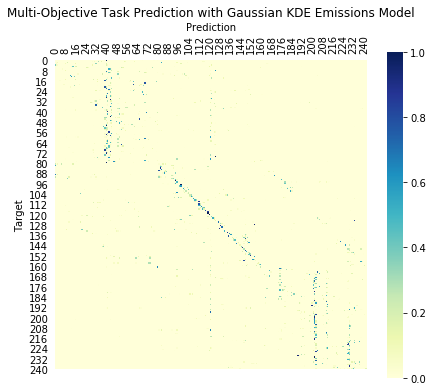

In [156]:
fig = plt.figure(figsize=(7, 6))
xmin = 0 #192
xmax = len(task_str) #218
ymin = 0 #110
ymax = len(task_str) #137
cm = cm.astype(float)
for row in range(cm.shape[0]):
    tot_freq = np.sum(cm[row, :])
    cm[row,:] = cm[row,:]/tot_freq
print(cm[0, :])
#sns.heatmap(cm, cmap='YlGnBu', square=1, annot=True, fmt="d", linewidths=1, xticklabels=task_names, yticklabels=task_names)
sns.heatmap(cm, cmap='YlGnBu', square=1)
#sns.heatmap(cm[ymin:ymax, xmin:xmax], cmap='YlGnBu', square=1, annot=False, xticklabels=task_names[xmin:xmax], yticklabels=task_names[ymin:ymax])
ax = plt.gca()
ax.xaxis.tick_top()
ax.tick_params(axis="x", rotation=90)
ax.tick_params(width=0)
ax.xaxis.set_label_position('top')
# plt.xticks(np.arange(len(task_names)), task_names, rotation=90)
#plt.xlim(0, len(task_names))
#plt.yticks(np.arange(len(task_names)), task_names, rotate=90)
#plt.ylim(len(task_names), 0)  # inverted range for "upper" origin
plt.ylabel('Target')
plt.xlabel('Prediction')
plt.title('Multi-Objective Task Prediction with Gaussian KDE Emissions Model')
plt.show()
